<a href="https://colab.research.google.com/github/LinarKulinar/ml-for-sec-lab2/blob/main/Get_feature_from_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
from random import random, randrange, randint

from operator import itemgetter

import os, sys
import pandas as pd

import pickle

## Получим изображения

In [2]:
# dir_name = 'BOWS2/'
dir_name = 'BOWS2/'
pictures = os.listdir(dir_name)
count_pictures = len(pictures)

imgs_raw = []
for k in range(count_pictures):
    im = cv2.imread(f'{dir_name}{pictures[k]}', 0)
    imgs_raw.append(im)

In [3]:
imgs = np.array(imgs_raw)

В качестве датасета BOWS-2 (выборка из 1000 чб изображений в формате TIFF): 

https://mega.nz/file/q0NBiTJD#81n-vQ6nBeDTUNWc7S_MhATunDZwYPyzLxFcdIr7z5M

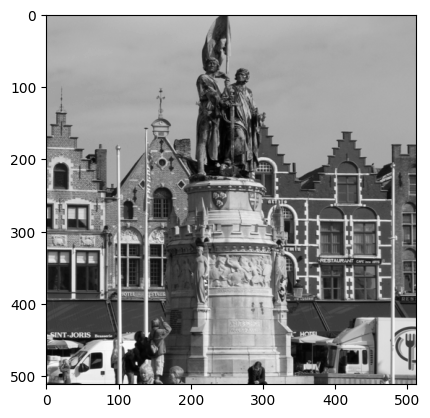

In [4]:
plt.imshow(imgs[0], cmap='gray')

## Глобальные важные переменные

In [5]:
# Доля изображений, которые будут подвержены НЗБ встраиванию
percentage_of_encoded_images = 0.5

# Вторая битовая плоскость
bitmap_number = 1

# Значения уровня заполнения изображений  секретной информацией с помощью НЗБ встраивания
list_padding_level = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]




assert isinstance(percentage_of_encoded_images, float)
assert percentage_of_encoded_images >= 0 and percentage_of_encoded_images <= 1

assert isinstance(bitmap_number, int)
assert bitmap_number >= 0 and bitmap_number < 8

assert (np.array(list_padding_level) >= 0).all()
assert (np.array(list_padding_level) <= 1).all()

## Реализуем НЗБ встраивание

In [6]:
def generate_bitmask_image_with_fixed_padding_level(image: np.ndarray, padding_level: float):
    """
    Генерируем маску - ключ для кодирования и декодирования с уровнем заподнения padding_level.
    В ненулевые значения маски будет закодирована информация
    """
    assert isinstance(image, np.ndarray)
    assert isinstance(padding_level, float)
    message_size = int(padding_level*image.size)  # сколько единиц в маске надо проставить 
    flatten_mask = np.zeros(image.size, dtype=int)  # инициализируем маску в виде одномерного массива (это надо для np.random.permutation), который потом будем решейпить
    flatten_mask[:message_size] = 1  # ставим единицы для первых message_size элементов
    mask = np.random.permutation(flatten_mask).reshape(image.shape)  # перемешиваем массив и решейпим
    del message_size
    del flatten_mask
    return mask

# Проверим рабоспособность функции

padding_level_test = 0.1

mask_coordinates = generate_bitmask_image_with_fixed_padding_level(imgs[0], padding_level_test)
padding_level_result = mask_coordinates.sum()/mask_coordinates.size
assert (padding_level_result - padding_level_test) < 0.00001
padding_level_result

del mask_coordinates
del padding_level_result

##### Реализуем непосредственную замену битовой плоскости изображения встроенной информацией

Нижеприведенная формула описывает это кодирование:

$ C_{p}^{W}(n_{1},n_{2}) = W(n_{1},n_{2}) $

Где $p$  - индекс битовой плоскости,

$W$ - значение интенсивности встраемого пикселя,

$C_{p}^{W}$ - итоговое значение интенсивности пикселя (но только не всё число, а в битовой плоскости $p$), со встроенными данными,

$(n_{1},n_{2})$ - два индекса пикселя на картинке

In [7]:
def encode_pix_with_replacing(pix: int, pix_secret: int, bitmap_number: int, mask: bool = True, debug_logs: bool = False):
    """
    Данный метод реализовывает НЗБ-встраивание заменой битовой плоскости.
    Keyword arguments:
    pix -- Пиксель изображения, в который встраивем код в НЗБ. Подразумевается, что переменная pix целочисленная и лежит в диапазоне [0, 255].
    pix_secret -- Пиксель изображения, который будем встраивать. Он должен быть целочисленным и лежать в диапазоне [0, 1].
    bitmap_number -- Номер битовой плоскости, в которую встраивается информация из pix_secret (отсчёт плоскостей начинается справа). Целое число в диапазоне [0, 7]
    mask -- если равен 0, то функция возвращает pix и не выполняет НЗБ встраивание. Иначе выполняет НЗБ встраивание. Нужно для кодировани информации по маске
    debug_logs -- флаг, включающий логи для дебага
    """
    assert str(pix).isdigit(), "в pix может хранится только целое число"
    assert str(pix_secret).isdigit(), "в pix может хранится только целое число"
    assert str(bitmap_number).isdigit(), "в pix может хранится только целое число"
    assert isinstance(debug_logs, bool)
    if (isinstance(mask, int)):
        assert mask in (0, 1)
    else:
        assert isinstance(mask, bool)
    
    if not mask: # Если ничего не надо делать, т.к. mask!=1
        return pix
    
    pix = int(pix)
    pix_secret = int(pix_secret)
    bitmap_number = int(bitmap_number)

    assert (pix_secret == 0) | (pix_secret == 1), "в pix_secret может хранится только целое число 0 или 1"
    assert (pix >=0) & (pix <= 255), "в pix может хранится только целое число в диапазоне [0, 255]"
    assert (bitmap_number >=0) & (bitmap_number <= 7), "в bitmap_number может хранится только целое число в диапазоне [0, 7]"

    if debug_logs:
        print("pix =", pix, "=", bin(pix), "- Это исходное восьмибитное число")

    # строим битмаску
    bitmask1 = 1 << bitmap_number # ставим единицу в разряд bitmap_number в битовом представлении числа с помощью операции побитового сдвига
    if debug_logs:
        print("bitmask1 =", bitmask1, "=", bin(bitmask1), "- Это число, у которого в разряде bitmap_number =", bitmap_number, "стоит единица, а в остальных разрядах ноль")

    bitmask_inverse = 255 - (bitmask1) # инвертируем bitmask1
    if debug_logs:
        print("bitmask_inverse =", bitmask_inverse, "=", bin(bitmask_inverse), "- Это число, у которого в разряде bitmap_number =", bitmap_number, "стоит ноль, а в остальных разрядах единица")

    # обнуляем бит под номером bitmap_number с помощью битмаски
    pix_with_zeros_nzb = pix & bitmask_inverse
    if debug_logs:
        print("pix_with_zeros_nzb =", pix_with_zeros_nzb, "=", bin(pix_with_zeros_nzb), "- Это число pix, у которого в разряде bitmap_number =", bitmap_number, "установили ноль")

    # Вот в формуле снизу разница всех модификаций, которая нужна в задании

    bitmask_with_pix_secret = pix_secret << bitmap_number # ставим pix_secret в разряд bitmap_number в битовом представлении числа с помощью операции побитового сдвига
    if debug_logs:
        print("bitmask_with_pix_secret =", bitmask_with_pix_secret, "=", bin(bitmask_with_pix_secret), "- Это число, у которого в разряде bitmap_number =", bitmap_number, "стоит значение pix_secret =", pix_secret, ", а в остальных разрядах ноль")
    pix_with_encoded_secret = pix_with_zeros_nzb | bitmask_with_pix_secret
    if debug_logs:
        print("pix_with_encoded_secret =", pix_with_encoded_secret, "=", bin(pix_with_encoded_secret), "- Это число pix =", pix, ", у которого в разряде bitmap_number =", bitmap_number, "стоит значение pix_secret =", pix_secret, ", а в остальных разрядах ноль")
    return pix_with_encoded_secret

# Проверим работоспособность функции
encode_pix_with_replacing(29, 1, 1, mask=True, debug_logs=True)

pix = 29 = 0b11101 - Это исходное восьмибитное число
bitmask1 = 2 = 0b10 - Это число, у которого в разряде bitmap_number = 1 стоит единица, а в остальных разрядах ноль
bitmask_inverse = 253 = 0b11111101 - Это число, у которого в разряде bitmap_number = 1 стоит ноль, а в остальных разрядах единица
pix_with_zeros_nzb = 29 = 0b11101 - Это число pix, у которого в разряде bitmap_number = 1 установили ноль
bitmask_with_pix_secret = 2 = 0b10 - Это число, у которого в разряде bitmap_number = 1 стоит значение pix_secret = 1 , а в остальных разрядах ноль
pix_with_encoded_secret = 31 = 0b11111 - Это число pix = 29 , у которого в разряде bitmap_number = 1 стоит значение pix_secret = 1 , а в остальных разрядах ноль


31

In [8]:
# Проверим работоспособность функции
encode_pix_with_replacing(27, 1, 1)

27

##### Векторизируем функцию `encode_pix_with_replacing` для того чтобы могли поэлементно к матрице применять

In [9]:
vec_func_encode_pix_with_replacing = np.vectorize(encode_pix_with_replacing)

### Генерируем матрицу с белым шумом и вставляем в вторую битовую плоскость

In [10]:
# Перемешиваем картинки в массиве (перемешивание идет только по первому изменению и картинки сами не изменяются)
imgs_shaffled = np.random.permutation(imgs)
del imgs

In [11]:
# Вычислим матрицы случайного заполнения заранее
mask_coordinates_list = []
for i, padding_level in enumerate(list_padding_level):
    mask = generate_bitmask_image_with_fixed_padding_level(imgs_shaffled[0], padding_level)
    mask_coordinates_list.append(mask)
    # Сохраним маску файл, если нам нужно будет декодировать сообщение
    with open(f'masks/mask_coordinates_with_padding_level_{padding_level}.pickle', 'wb') as handle:
        pickle.dump(mask, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
def generate_dataset_with_NZB(imgs: np.array, percentage_of_encoded_images: float, bitmap_number: int, mask_coordinates: np.array):
    """
    Функция возвращает imgs, среди которых percentage_of_encoded_images изображений 
    было подвержено НЗБ встраиванию в bitmap_number плоскость. 
    Причем встраивались случайные числа в значения определяемые маской mask_coordinates.
    """
    num_pictures = len(imgs)
    # Количество изображений, которые будут подвержены НЗБ встраиванию
    num_pictures_for_NZB = int(percentage_of_encoded_images * num_pictures)
    print("num_pictures_for_NZB =", num_pictures_for_NZB)

    imgs_with_encoded_secret = np.zeros(imgs.shape, dtype=imgs_shaffled.dtype)  # Выделяем память под итоговый массив картинок
    labels_imgs = np.zeros(num_pictures)  # Выделяем память под метки классов
    for i in range(num_pictures_for_NZB):
        #print("i =",i)
        img = imgs[i]
        
        img_secret_binary = np.zeros(img.shape, dtype=int)
        img_secret_binary_raw = np.random.randint(0, high=2, size=mask_coordinates.sum(), dtype=int)
        img_secret_binary[mask_coordinates == 1] = img_secret_binary_raw
        del img_secret_binary_raw

        data_with_with_encoded_secret = vec_func_encode_pix_with_replacing(img, img_secret_binary, bitmap_number) 
        #print('Data shape:',data_with_with_encoded_secret.shape)
        #print('Data type:',type(data_with_with_encoded_secret))
        # Заполняем постепенно массив изображенями после НЗБ встраивания
        imgs_with_encoded_secret[i,:,:] = data_with_with_encoded_secret
        labels_imgs[i] = 1  # Отмечаем, что изображение было подвержено НЗБ встраиванию 

    # Допиcываем в конец массива imgs_with_encoded_secret неизменившиеся (num_pictures - num_pictures_for_NZB) изображения
    imgs_with_encoded_secret[num_pictures_for_NZB:,:,:] = imgs[num_pictures_for_NZB:,:,:]
    labels_imgs[num_pictures_for_NZB:] = 0 # Отмечаем, что изображение не было подвержено НЗБ встраиванию 
    
    return (imgs_with_encoded_secret, labels_imgs)
    
# Проверим функцию
# imgs_with_encoded_secret, labels_imgs = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[2])

In [13]:
# imgs_with_encoded_secret.shape

In [14]:
# plt.imshow(imgs_with_encoded_secret[0], cmap='gray')
# plt.show()

In [15]:
# del imgs_with_encoded_secret
# del labels_imgs 

#### Генерируем датасет

Пробежимся по разным значениям list_padding_level и сохраним в файл полученные изображения

In [16]:
# imgs_with_encoded_secret_0, labels_imgs_0 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[0])

In [17]:
# for k in range(len(imgs_with_encoded_secret_0)):
#     cv2.imwrite(f'encoded_images_all/padding_level_0.0/Image{k:5}.tiff', imgs_with_encoded_secret_0[k])
# with open(f'encoded_images_all/padding_level_0.0/labels.pickle', 'wb') as handle:
#     pickle.dump(labels_imgs_0, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
imgs_with_encoded_secret_1, labels_imgs_1 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[1])

num_pictures_for_NZB = 500


In [19]:
for k in range(len(imgs_with_encoded_secret_1)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.1/Image{k:5}.tiff', imgs_with_encoded_secret_1[k])

In [20]:
imgs_with_encoded_secret_2, labels_imgs_2 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[2])

num_pictures_for_NZB = 500


In [21]:
for k in range(len(imgs_with_encoded_secret_2)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.2/Image{k:5}.tiff', imgs_with_encoded_secret_2[k])

In [ ]:
imgs_with_encoded_secret_3, labels_imgs_3 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[3])

num_pictures_for_NZB = 500


In [ ]:
for k in range(len(imgs_with_encoded_secret_3)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.3/Image{k:5}.tiff', imgs_with_encoded_secret_3[k])

In [ ]:
imgs_with_encoded_secret_4, labels_imgs_4 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[4])

In [ ]:
for k in range(len(imgs_with_encoded_secret_4)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.4/Image{k:5}.tiff', imgs_with_encoded_secret_4[k])

In [ ]:
imgs_with_encoded_secret_5, labels_imgs_5 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[5])

In [ ]:
for k in range(len(imgs_with_encoded_secret_5)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.5/Image{k:5}.tiff', imgs_with_encoded_secret_5[k])

In [ ]:
imgs_with_encoded_secret_6, labels_imgs_6 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[6])

In [ ]:
for k in range(len(imgs_with_encoded_secret_6)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.6/Image{k:5}.tiff', imgs_with_encoded_secret_6[k])

In [ ]:
imgs_with_encoded_secret_7, labels_imgs_7 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[7])

In [ ]:
for k in range(len(imgs_with_encoded_secret_7)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.7/Image{k:5}.tiff', imgs_with_encoded_secret_7[k])

In [ ]:
imgs_with_encoded_secret_8, labels_imgs_8 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[8])

In [ ]:
for k in range(len(imgs_with_encoded_secret_8)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.8/Image{k:5}.tiff', imgs_with_encoded_secret_8[k])

In [ ]:
imgs_with_encoded_secret_9, labels_imgs_9 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[9])

In [ ]:
for k in range(len(imgs_with_encoded_secret_9)):
    cv2.imwrite(f'encoded_images_all/padding_level_0.9/Image{k:5}.tiff', imgs_with_encoded_secret_9[k])

In [ ]:
# imgs_with_encoded_secret_10, labels_imgs_10 = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[10])

In [14]:
imgs_with_encoded_secret_all, labels_imgs_all = generate_dataset_with_NZB(imgs_shaffled, percentage_of_encoded_images, bitmap_number, mask_coordinates_list[10])

num_pictures_for_NZB = 500
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i =

In [16]:
for k in range(len(imgs_with_encoded_secret_all)):
    cv2.imwrite(f'encoded_images_all/padding_level_1.0/Image{k:5}.tiff', imgs_with_encoded_secret_all[k])

In [18]:
with open(f'encoded_images_all/padding_level_1.0/labels.pickle', 'wb') as handle:
    pickle.dump(labels_imgs_all, handle, protocol=pickle.HIGHEST_PROTOCOL)